In [1]:
# Standard imports:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

**To-do:**
1. Try witout stop-words as removing them may change the meaning of the sentence
2. Don't stem as it reduces overlap with embeddings vocabulary
3. Change N_SEQ based on mean + 3\*sigma
4. Try FastText embeddings

In [15]:
# Constants:

# Contains 1.6M samples
PATH_DATA = "../input/sentiment140/training.1600000.processed.noemoticon.csv"

# 2B tweets, 27B tokens, 1.2M vocab, uncased,200-dimensional
PATH_EMB = "../input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt"

# Dimensions of the embeddings
N_EMB = 200

# Number of samples to be taken
LIMIT = 1000000

# Fraction of samples to be used for training set
N_TRAIN = 0.9

# Size of each sequence to be embedded:
N_SEQ = 0 # Chosen later based on the histogram of the lengths

## Data reading and pre-processing

In [3]:
# Function that returns the processed dataframe
def loadDF(n_samples):
    
    # Read
    df = pd.read_csv(
        PATH_DATA, 
        encoding = "latin", # No encoding results in decode error 
        header = None
    )
    
    # Drop columns which aren't needed
    df.drop(labels = [1,2,3,4], axis = "columns", inplace = True)
    df.columns = ["Label", "Text"]
    
    # Relabel 0 -> 0 and 4 -> 1 (0:Negative, 1:Positive)
    df.replace(to_replace = 4, value = 1, inplace = True)
    
    # Training on 1.6M samples takes a lot of time, we train on a smaller randomized subset of the data
    df = df.sample(n = n_samples, random_state = 42)
    
    return df

In [4]:
df = loadDF(LIMIT)
print("Class distribution:\n{}".format(df["Label"].value_counts()))

Class distribution:
0    500167
1    499833
Name: Label, dtype: int64


## Cleaning the data:

In [5]:
# Check for null values
check = df.isnull().sum()
print(check)

Label    0
Text     0
dtype: int64


In [8]:
import re
import nltk
import string
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, TweetTokenizer

puncs = string.punctuation
sw = stopwords.words("english")
sb = SnowballStemmer(language = "english") # Better and faster than PorterStemmer
# https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove mentions (@username), all URLs, all hashtags.  (\S+ matches with everything that is not a whitespace)
    text = re.sub("@\S+|http\S+|#\S+", "", text)
    # Remove punctuations (Redundant step, handled later in Keras tokenizer)
    text.translate(str.maketrans('', '', puncs))
    # Strip off accents (convert to ascii)
    text = unidecode(text)
    # Tokenize
    tokenized_text = word_tokenize(text)
    # Don't stem as overlap with embeddings vocab is close to 0 
    # DON'T remove stop words as they carry imp info about the meaning of the sentence and non-alphanumeric tokens
    cleaned_tokens = [t for t in tokenized_text if t.isalnum()]
    cleaned_string = " ".join(cleaned_tokens)
    return cleaned_string

In [9]:
def cleanDF(df):
    df["Text"] = df["Text"].apply(lambda x : preprocess(x))
    return df

In [10]:
# This takes a lot of time
## 4.656230688095093 for 10000 samples, scales linearly, thus ~12.5 mins for entire set
## 3.301717519760132 without stemming for 10000 samples
df = cleanDF(df)
display(df)

,Label,Text
541200,0,ahhh i hope your ok
750,0,cool i have no tweet apps for my razr 2
766711,0,i know just family drama its next time u hang ...
285055,0,school email wo open and i have geography stuf...
705995,0,upper airways problem
...,...,...
21340,0,bad times lap top is broken good times found a...
80620,0,yeah not fun so what you think of the movie
411912,0,ministry of agriculture and forests they keep ...
798815,0,sad news farrah fawcett just passed away


## WordCloud visualization:

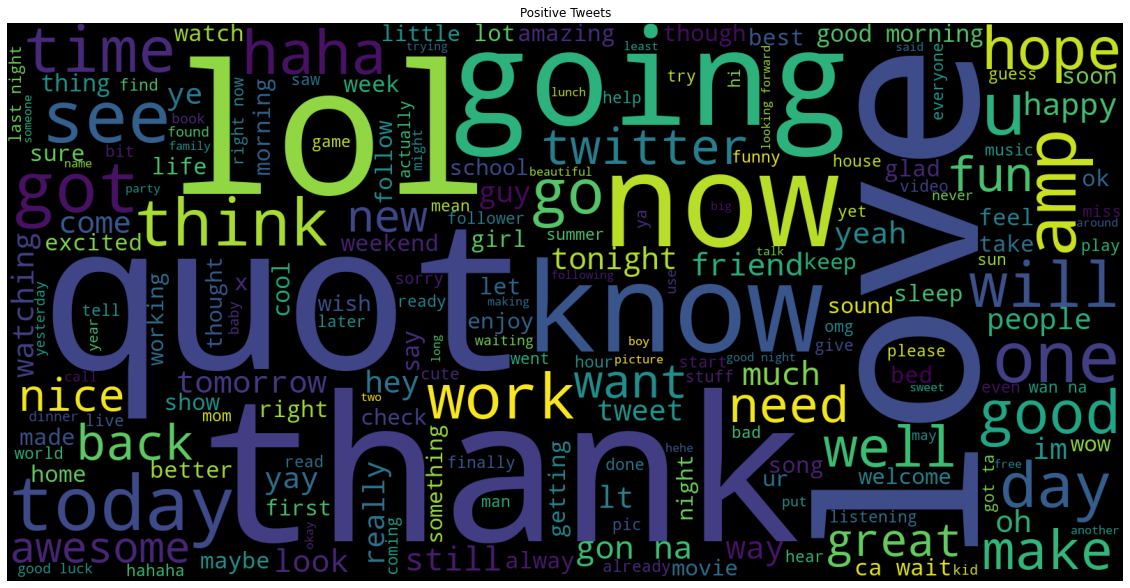

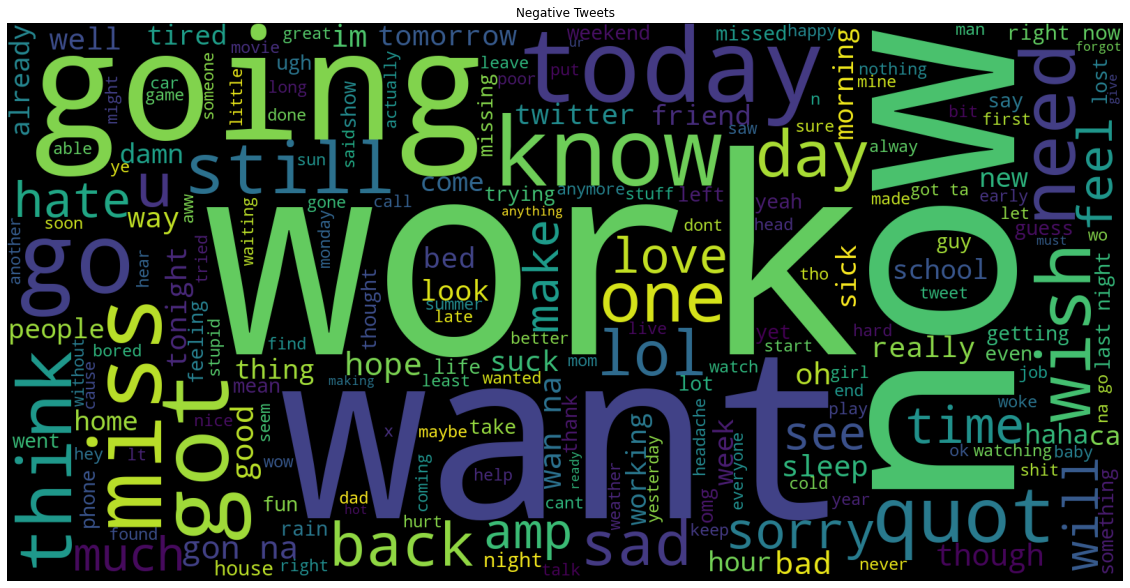

In [11]:
from wordcloud import WordCloud

df_pos = df.loc[df["Label"] == 1]
df_neg = df.loc[df["Label"] == 0]

wc_pos = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_pos["Text"])) 

wc_neg = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_neg["Text"])) 

plt.figure(figsize = (20,20))
plt.imshow(wc_pos)
plt.title("Positive Tweets")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(wc_neg)
plt.title("Negative Tweets")
plt.axis("off")
plt.show()

## Analyze the length of the tweets:
This will help us select the `N_SEQ`

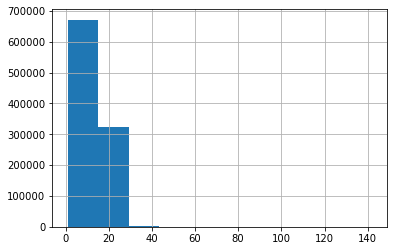

Mean: 12.466742
Std: 6.926716241108826
Mean+3*Std = 33.24689072332647


In [14]:
lengths = df["Text"].apply(lambda x : len(x.split(" "))) # try mean + 3*sigma
lengths.hist()
plt.show()

mean = lengths.mean()
std = lengths.std()
approx_nseq = mean + 3*std
print(f"Mean: {mean}\nStd: {std}\nMean+3*Std = {approx_nseq}")

Thus we keep `N_SEQ = 32` (Power of 2)

In [16]:
N_SEQ = 32

## Preparation before model training

In [17]:
from sklearn.model_selection import train_test_split as tts

# Split into training and validation sets
df_train, df_val = tts(df, train_size = N_TRAIN, shuffle = True, random_state = 42)

In [18]:
from keras.preprocessing.text import Tokenizer

def getTokenizer():
    tok = Tokenizer()
    # Create word_index and vocab
    tok.fit_on_texts(df_train["Text"])
    return tok

In [19]:
tok = getTokenizer()
word_index = tok.word_index
N_vocab = len(tok.word_index) + 1 # This +1 is used later 
print(N_vocab)

187784


In [20]:
from keras.preprocessing.sequence import pad_sequences

def getXY(tok):
    x_train = pad_sequences(tok.texts_to_sequences(df_train["Text"]), maxlen = N_SEQ, padding = "post")
    x_val   = pad_sequences(tok.texts_to_sequences(df_val["Text"]), maxlen = N_SEQ, padding = "post")
    y_train = df_train["Label"].to_numpy(dtype = float).reshape(-1, 1)
    y_val   = df_val["Label"].to_numpy(dtype = float).reshape(-1, 1)
    return x_train, x_val, y_train, y_val

In [21]:
x_train, x_val, y_train, y_val = getXY(tok)

## Preparing the Embedding layer
Reference: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [22]:
# Maps each word in the embeddings vocabulary to it's embedded representation 
embeddings_index = {}
with open(PATH_EMB, "r", errors="ignore") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

In [24]:
# Maps each word in our vocab to it's embedded representation, if the word is present in the GloVe embeddings
embedding_matrix = np.zeros((N_vocab, N_EMB))
n_match = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        n_match += 1
        embedding_matrix[i] = embedding_vector
print(n_match)

100505


This means 100000/187784 only match with the Twitter GloVe embeddings (We can improve this)

## The Model:

In [25]:
# Model constants:
LR = 0.001 # Default for Adam
N_BATCH = 256
N_EPOCHS = 5

In [40]:
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Embedding, Conv1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D

def buildModel():
    
    # The input as sequences:
    input_layer = Input(shape=(N_SEQ,))
    # Create the embedding layer
    embedding_layer = Embedding(
        N_vocab,
        N_EMB,
        weights = [embedding_matrix],
        input_length = N_SEQ,
        trainable = False # No need to train as our embeddings are already finetuned on Twitter data
    )
    # Create the embeddings
    embedded_sequences = embedding_layer(input_layer)
    
    # The core of the model:
    ## Learn spatial/postional features via 1D CNN
    # x = Conv1D(filters = 128, kernel_size = 3, activation = "relu")(embedded_sequences)
    
    ## 2-layered BiLSTM architecture
    # x = Bidirectional(LSTM(64, dropout = 0.2,recurrent_dropout = 0.2, return_sequences = True))(embedded_sequences)
    x = Bidirectional(LSTM(64, dropout = 0.2,recurrent_dropout = 0.2))(embedded_sequences) 
    
    # Fully connected classifer
    x = Dense(32, activation = "relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation = "relu")(x)

    # A rule of thumb is to have the number of hidden units be in-between the number of input units (200) and output classes (2)
    
    # Fully connected classifer (can be improved a lot):
    outputs = Dense(1, activation = "sigmoid")(x)
    
    model = Model(input_layer, outputs)
    return model

In [41]:
model = buildModel()

model.compile(
    optimizer = Adam(learning_rate = LR), 
    loss = "binary_crossentropy", # As binary classification
    metrics = ["accuracy"] # Balanced classes, thus good enough metric
)

callbacks_list = [
    ModelCheckpoint(filepath = "model_{epoch:02d}_{val_loss:.2f}.h5"),
]

print(model.summary())

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 32, 200)           37556800  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 128)               135680    
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

## Training:

In [42]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size = N_BATCH, 
    epochs = N_EPOCHS,
    validation_data = (x_val, y_val), 
    callbacks = callbacks_list
)

Epoch 1/5
3516/3516 [==============================] - 873s 248ms/step - loss: 0.4495 - accuracy: 0.7883 - val_loss: 0.4134 - val_accuracy: 0.8128
Epoch 2/5
3516/3516 [==============================] - 859s 244ms/step - loss: 0.4125 - accuracy: 0.8104 - val_loss: 0.4024 - val_accuracy: 0.8156
Epoch 3/5
3516/3516 [==============================] - 868s 247ms/step - loss: 0.3986 - accuracy: 0.8175 - val_loss: 0.3880 - val_accuracy: 0.8244
Epoch 4/5
3516/3516 [==============================] - 873s 248ms/step - loss: 0.3903 - accuracy: 0.8225 - val_loss: 0.3839 - val_accuracy: 0.8267
Epoch 5/5
3516/3516 [==============================] - 888s 253ms/step - loss: 0.3839 - accuracy: 0.8256 - val_loss: 0.3804 - val_accuracy: 0.8284


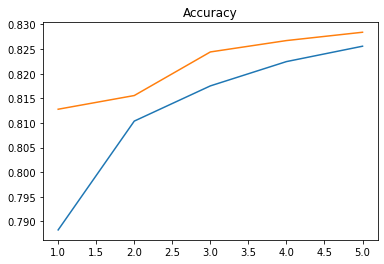

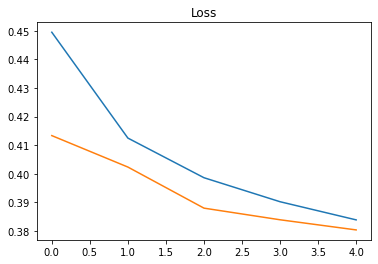

In [43]:
metrics = history.history
t_acc = metrics["accuracy"]
t_loss = metrics["loss"]
v_acc = metrics["val_accuracy"]
v_loss = metrics["val_loss"]

epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, t_acc)
plt.plot(epochs, v_acc)
plt.title("Accuracy")

plt.figure()
plt.plot(t_loss)
plt.plot(v_loss)
plt.title("Loss")

plt.show()

Going by the plots, training for more epochs and choosing the proper hyperparameters can increase the accuracy even more.